
🔍 Confusion matrix


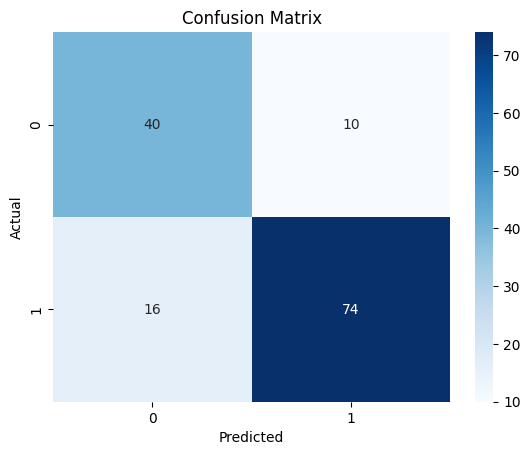

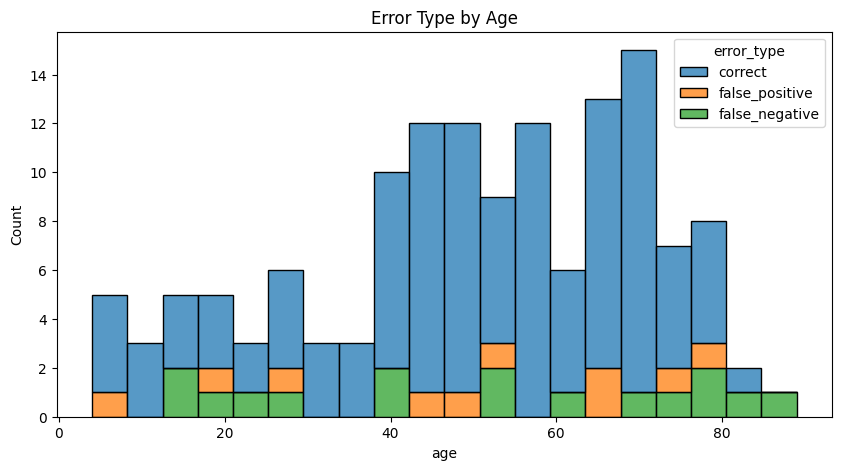

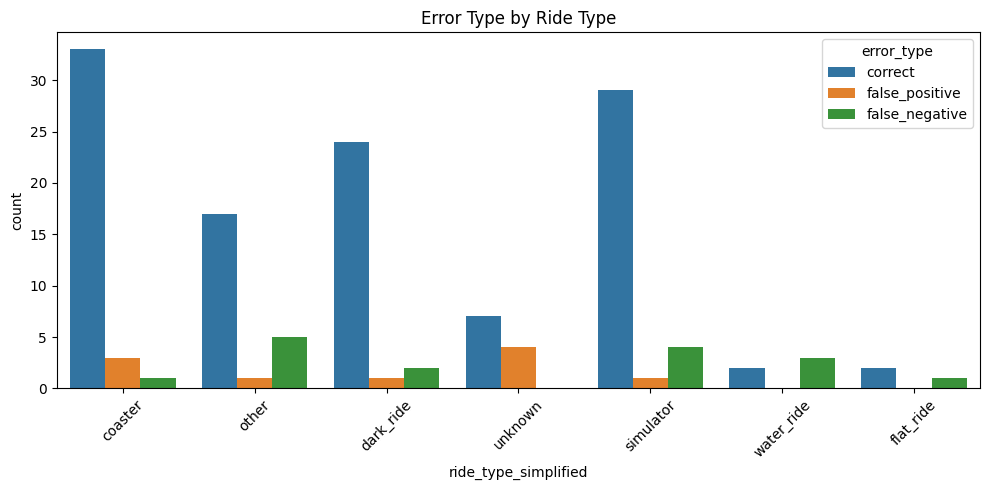

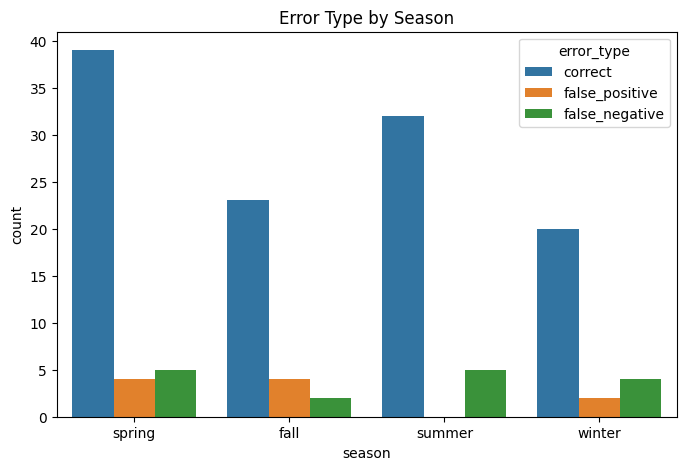

In [2]:
# notebooks/modeling/05_model_error_analysis.ipynb

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 1. Load dataset
df = pd.read_parquet("../../data/processed/model_ready.parquet")
target = "incident_occurred"
features = [
    "ride_type_simplified", "ride_incident_count", "duration_min",
    "age", "gender", "simulated_medical_condition", "first_time_visitor",
    "season", "is_weekend", "temperature_max", "precipitation_sum"
]
df_model = pd.get_dummies(df[features + [target]], drop_first=True).dropna()

# 2. Train/test split
X = df_model.drop(columns=target)
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 4. Build error dataframe
y_true = y_test.reset_index(drop=True)
df_errors = df.loc[y_test.index].copy()
df_errors["y_true"] = y_true.values
df_errors["y_pred"] = y_pred

df_errors["error_type"] = "correct"
df_errors.loc[(df_errors["y_true"] == 1) & (df_errors["y_pred"] == 0), "error_type"] = "false_negative"
df_errors.loc[(df_errors["y_true"] == 0) & (df_errors["y_pred"] == 1), "error_type"] = "false_positive"

# 5. Visualizations
print("\n🔍 Confusion matrix")
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 6. Error distribution by age
plt.figure(figsize=(10, 5))
sns.histplot(data=df_errors, x="age", hue="error_type", multiple="stack", bins=20)
plt.title("Error Type by Age")
plt.show()

# 7. Error distribution by ride type
plt.figure(figsize=(10, 5))
sns.countplot(data=df_errors, x="ride_type_simplified", hue="error_type")
plt.title("Error Type by Ride Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. Error distribution by season
plt.figure(figsize=(8, 5))
sns.countplot(data=df_errors, x="season", hue="error_type")
plt.title("Error Type by Season")
plt.show()
